In [1]:
# Python control flow and logic operators are evaluated at JIT compile time, such that the compiled function represents
# a single path through the control flow graph.
# If the path depends on the values of the function input, then the function, by default, cannot be JIT compiled.

In [2]:
# The path may depend on the shape or dtype of the inputs, and the function is re-compiled everytime it is called on an input
# with a new shape or dtype.

In [3]:
from jax import jit, grad, vmap
import jax.numpy as jnp

In [5]:
@jit
def f(x):
    if x < 3:
        return 0
    else:
        return 1
f(2)

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[].
The error occurred while tracing the function f at /tmp/ipykernel_3791521/2555194657.py:1 for jit. This concrete value was not available in Python because it depends on the value of the argument x.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

In [6]:
@jit
def g(x):
  return (x > 0) and (x < 3)

# This will fail!
g(2)

TracerBoolConversionError: Attempted boolean conversion of traced array with shape bool[].
The error occurred while tracing the function g at /tmp/ipykernel_3791521/543860509.py:1 for jit. This concrete value was not available in Python because it depends on the value of the argument x.
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerBoolConversionError

In [32]:
# Essentially, you cant use logic operators on the "VALUES" of the inputs when jitting.
# Caviat: jax.numpy provides logical_and, logical_or, and logical_not, which operate element-wise on arrays and can be 
# evaluated under jit without recompiling.
# Like their Numpy counterparts, the binary operators do not short circuit. Bitwise operators (&, |, ~) can also be used with jit.

To get a view of your python code that is valid for many different argument values, jax traces it with ShapedArray abstraction as input, where each abstract value represents the set of all array values with a fixed shape and dtype.

When tracing with input ShapedArray((), jnp.float32), x<3 evaluates to {True, False}, and cannot be concreted to one of the values.

You can define certain arguments to be static. This way, for every specific value of that argument, the code is compiled once.

In [8]:
def f(x):
  if x < 3:
    return 3. * x ** 2
  else:
    return -4 * x

f = jit(f, static_argnames='x')

print(f(2.))

12.0


In [9]:
def f(x, n):
  y = 0.
  for i in range(n):
    y = y + x[i]
  return y

f = jit(f, static_argnames='n')

f(jnp.array([2., 3., 4.]), 2)

Array(5., dtype=float32)

In [12]:
# You cant use the argument value's shapes for contitions or initializations.
def example_fun(length, val):
  return jnp.ones((length,)) * val
# un-jit'd works fine
print(jit(example_fun)(5, 4))

In [13]:
good_example_jit = jit(example_fun, static_argnames='length')


## Structured control flow primitives

Suppose you want to use control flow, and still want to use jit, and avoid re-compilations, and avoid unrolling large loops,
you have 4 primitives:

* lax.cond : differentiable
* lax.while_loop: fwd-mode-differentiable
* lax.fori_loop: fwd-mode-differentiable in general; fwd and rev-mode differentiable if endpoints are static.
* lax.scan: differentiable

In [14]:
from jax import lax

In [19]:
operand = jnp.array([-1., 0., 1.])

In [22]:
# Syntax: lax.cond(conditional statement, function to apply on true, function to apply on false, operand)
lax.cond(all(operand > 0), lambda x: 1, lambda x: -1, operand)

Array(-1, dtype=int32, weak_type=True)

In [23]:
operand = jnp.array([2., 3., 1.])

In [24]:
# Syntax: lax.cond(conditional statement, function to apply on true, function to apply on false, operand)
lax.cond(all(operand > 0), lambda x: 1, lambda x: -1, operand)

Array(1, dtype=int32, weak_type=True)

In [25]:
"""

    lax.select is like a batched version of lax.cond, with the choices expressed as pre-computed arrays rather than as functions.

    lax.switch is like lax.cond, but allows switching between any number of callable choices.
"""

'\n\n    lax.select is like a batched version of lax.cond, with the choices expressed as pre-computed arrays rather than as functions.\n\n    lax.switch is like lax.cond, but allows switching between any number of callable choices.\n'

In [26]:
init_val = 0
cond_fun = lambda x: x < 10
body_fun = lambda x: x+1
lax.while_loop(cond_fun, body_fun, init_val)

Array(10, dtype=int32, weak_type=True)

In [31]:
@jit
def f(x):
    init_val = 0
    start = 0
    stop = x
    body_fun = lambda i,x: x+i
    lax.fori_loop(start, stop, body_fun, init_val)
    return x
    
    
print(f(10))

10


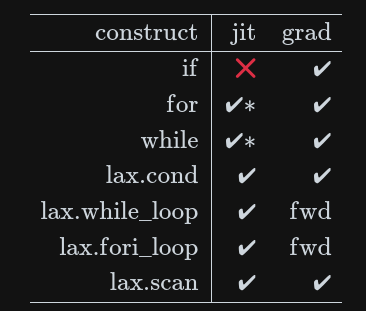

In [35]:
def python_check_positive_even(x):
  is_even = x % 2 == 0
  # `and` short-circults, so when `is_even` is `False`, `x > 0` is not evaluated.
  return is_even and (x > 0)

@jit
def jax_check_positive_even(x):
  is_even = x % 2 == 0
  # `logical_and` does not short circuit, so `x > 0` is always evaluated.
  return jnp.logical_and(is_even, x > 0)

print(python_check_positive_even(24))
print(jax_check_positive_even(24))

True
True
